In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


## 데이터 불러오기 및 데이터셋 생성

In [3]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder  # LabelEncoder를 사용하기 위해 임포트
from sklearn.model_selection import train_test_split  # train_test_split을 사용하기 위해 임포트
import os  # 파일 및 디렉토리 관리를 위해 임포트
import cv2  # OpenCV 라이브러리를 사용하기 위해 임포트
import numpy as np  # 배열 및 행렬 작업을 위해 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위해 임포트
import seaborn as sns  # 시각화를 위해 Seaborn 라이브러리 임포트

# 데이터 로드 함수 정의
def load_data(data_directory):
    images = []  # 이미지 데이터를 저장할 리스트
    labels = []  # 레이블 데이터를 저장할 리스트
    classes = []  # 클래스 목록을 저장할 리스트
    label_encoder = LabelEncoder()  # LabelEncoder 객체 생성

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):  # 디렉토리인 경우에만 처리
            classes.append(class_name)

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)  # 이미지 파일 읽기
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
                    img = cv2.resize(img, (224, 224))  # 크기 조정
                    img = img / 255.0  # 정규화
                    images.append(img)  # 이미지 리스트에 추가
                    labels.append(class_name)  # 레이블 리스트에 클래스 이름 추가

    images = np.array(images)  # 이미지 데이터를 NumPy 배열로 변환
    labels = label_encoder.fit_transform(labels)  # 레이블을 숫자로 변환
    classes = label_encoder.classes_  # 클래스 목록을 저장

    return images, labels, classes

# 훈련 데이터셋 로드
train_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/Train'
train_images, train_labels, train_classes = load_data(train_data_directory)

# 테스트 데이터셋 로드
test_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/test'
test_images, test_labels, test_classes = load_data(test_data_directory)

# 검증 데이터셋 로드
valid_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/valid'
valid_images, valid_labels, valid_classes = load_data(valid_data_directory)

### 데이터셋별 클래스 분포 살펴보기

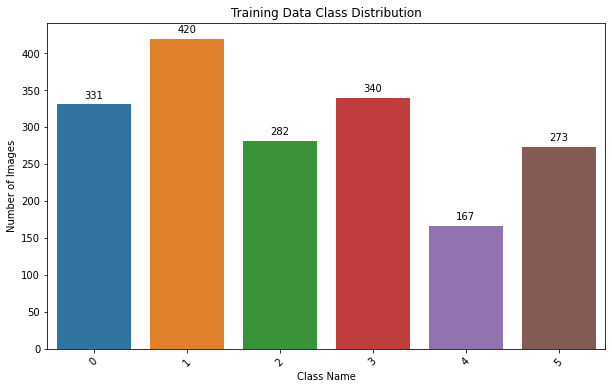

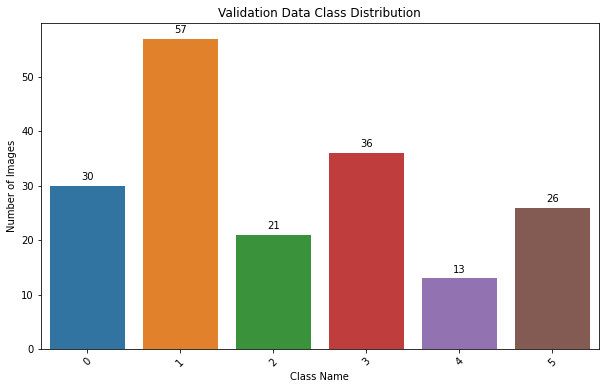

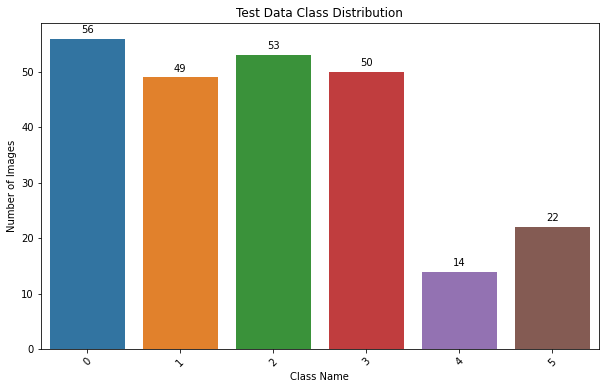

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스별 이미지 개수 계산 함수
def plot_class_distribution(images, labels, title):
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    # 막대 그래프 그리기
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x=class_counts.index, y=class_counts.values)
    
    # 각 막대에 숫자 표시
    for p in barplot.patches:
        barplot.annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')
    
    # 그래프 제목 및 레이블 설정
    plt.title(title)
    plt.xlabel('Class Name')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.show()

# 학습 데이터셋 시각화
plot_class_distribution(train_images, train_labels, 'Training Data Class Distribution')

# 검증 데이터셋 시각화
plot_class_distribution(valid_images, valid_labels, 'Validation Data Class Distribution')

# 테스트 데이터셋 시각화
plot_class_distribution(test_images, test_labels, 'Test Data Class Distribution')

In [5]:
# 훈련 데이터셋 이미지 shape 확인
print("훈련 데이터셋(train_images) 이미지의 shape:", train_images.shape)

# 테스트 데이터셋 이미지 shape 확인
print("테스트 데이터셋(test_images) 이미지의 shape:", test_images.shape)

# 검증 데이터셋 이미지 shape 확인
print("검증 데이터셋(valid_images) 이미지의 shape:", valid_images.shape)

훈련 데이터셋(train_images) 이미지의 shape: (1813, 224, 224, 3)
테스트 데이터셋(test_images) 이미지의 shape: (244, 224, 224, 3)
검증 데이터셋(valid_images) 이미지의 shape: (183, 224, 224, 3)


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 증강을 위한 데이터 제너레이터 생성
datagen = ImageDataGenerator(
    rotation_range=30,         # 이미지를 랜덤하게 30도 회전
    width_shift_range=0.1,     # 가로로 10%까지 랜덤하게 이동
    height_shift_range=0.1,    # 세로로 10%까지 랜덤하게 이동
    shear_range=0.1,           # 레이어를 변형
    zoom_range=0.3,            # 30% 범위로 확대 또는 축소
    horizontal_flip=True,      # 가로로 뒤집기
    vertical_flip=True,        # 세로로 뒤집기
)

datagen1 = ImageDataGenerator()

# 데이터 증강을 위한 데이터 제너레이터 생성
train_datagen = datagen.flow(train_images, train_labels, batch_size=20)
val_datagen = datagen1.flow(valid_images, valid_labels, batch_size=20)

### 데이터셋 이미지 시각화

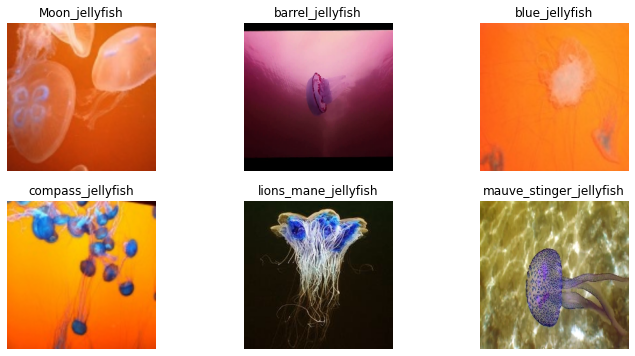

In [7]:
import random

# 클래스의 이름과 수를 파악합니다.
class_names = train_classes  # train_images에서 train_classes로 변경
num_classes = len(class_names)

# 1행: 클래스 별로 랜덤한 이미지 선택하여 출력
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    class_images = train_images[train_labels == i]  # 해당 클래스의 이미지 가져오기
    if len(class_images) > 0:  # 해당 클래스에 이미지가 있는지 확인
        random_index = random.randint(0, len(class_images) - 1)  # 랜덤한 이미지 인덱스 선택
        selected_image = class_images[random_index]

        # 이미지를 정규화 해제하여 BGR 색상으로 변환
        restored_image = selected_image * 255.0  # 정규화를 해제하기 위해 255를 곱합니다.
        restored_image = restored_image.astype("uint8")  # 정수형 데이터로 변환합니다.
        restored_image = cv2.cvtColor(restored_image, cv2.COLOR_RGB2BGR)  # RGB에서 BGR로 변환합니다.

        plt.subplot(2, 3, i + 1)
        plt.imshow(restored_image)
        plt.title(class_names[i])  # 클래스 이름을 제목으로 표시
        plt.axis("off")

plt.show()

# 배깅을 활용한 CNN모델 앙상블

🤔 배깅(Bagging, Bootstrap Aggregating)

- 모델을 앙상블하는 방법중 하나로 훈련데이터셋에서 여러개의 Bootstrap 표본을 무작위 추출하여 각 표본에 대해 classifier를 독립적으로 훈련시킵니다.
- 이후 훈련된 classifier들의 prediction을 결합(voting)해서 최종 prediction을 만들어 냅니다.

- CNN모델의 앙상블로 배깅을 선택한 이유
    - CNN은 기본적으로 이미지 분류에 매우 효과적인 알고리즘 입니다.
    - 특히 지역적 패턴을 인식하는데 뛰어난 모델입니다.
    - CNN을 배깅에 적용하면 각 표본에 대해 CNN이 독립적으로 훈련이되고, 훈련된 각 CNN모델이 데이터셋의 조금씩 다른 특서을 학습하기 때문에 모델의 예측을 결합할때 더 강건한 최종 예측이 가능합니다.
   - 또한, 이번 DLthon에서 가장 큰 문제였던 데이터의 과적합 부분을 방지하는데 유용하며, prediction의 안정성을 추구할 수 있습니다.
   - 이것이 가능한 이유는 각 classifier가 독립적으로 훈련되어 error간의 상관관계가 없기 때문입니다.
   
---

- 다만 현재는 모두 같은 학습데이터를 사용해 학습한 모델이므로 별도의 학습과정없이 Prediction하는 과정만을 구현합니다.

### 저장된 모델 불러오기

In [8]:
from keras.models import load_model
import numpy as np

models = []

# 저장된 모델 파일 목록
model_files = ['model/CNN_V2_adddata_best_model_epoch_130.h5', 'model/hj_cnn_model.h5', 'model/CNN_Best_Model_Acc_71_LSJ.h5']

# 모델들을 불러와서 리스트에 저장
models = [load_model(model_file) for model_file in model_files]

# 모델들을 불러오고 이름을 설정
for model_file in model_files:
    model = load_model(model_file)
    model.custom_name = model_file.split('/')[-1]  # 사용자 지정 이름으로 설정
    models.append(model)

### Prediction 수행

In [9]:
def ensemble_predictions(models, test_images):
    # 각 모델에 대한 예측값을 저장할 리스트
    predictions = []

    # 모든 모델을 순회하면서 예측 수행
    for model in models:
        pred = model.predict(test_images)
        predictions.append(pred)

    # 예측값들의 평균을 계산
    avg_predictions = np.mean(predictions, axis=0)
    
    return avg_predictions

# 앙상블을 통한 예측 수행
ensemble_pred = ensemble_predictions(models, test_images)

# 최종 예측 결과
final_predictions = np.argmax(ensemble_pred, axis=1)

### 결과 평가

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 실제 테스트 레이블과 앙상블 모델의 예측 결과 비교
# 정확도 계산
ensemble_accuracy = accuracy_score(test_labels, final_predictions)
print(f"정확도: {ensemble_accuracy}")

# 정밀도 계산
ensemble_precision = precision_score(test_labels, final_predictions, average='macro')
print(f"정밀도: {ensemble_precision}")

# 재현율 계산
ensemble_recall = recall_score(test_labels, final_predictions, average='macro')
print(f"재현율: {ensemble_recall}")

# F1 점수 계산
ensemble_f1 = f1_score(test_labels, final_predictions, average='macro')
print(f"F1 점수: {ensemble_f1}")

정확도: 0.7418032786885246
정밀도: 0.7142171106937564
재현율: 0.7163197337253941
F1 점수: 0.7072219887985898


### Confusion Matrix

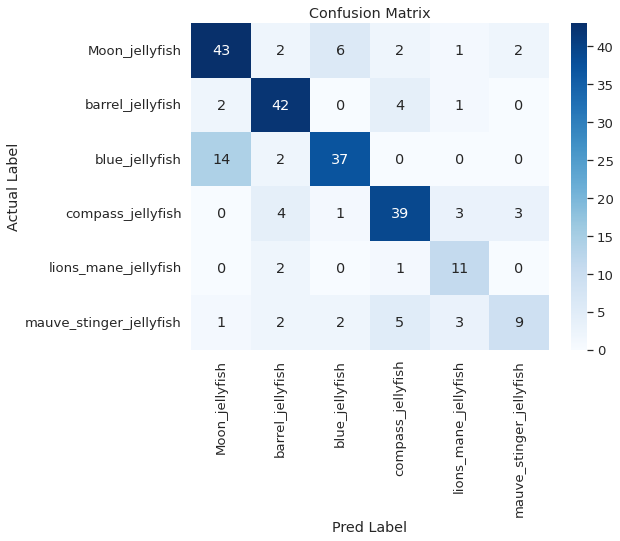

In [11]:
# 필요한 라이브러리 가져오기
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_labels, final_predictions)

# 그래프 스타일 설정 (선택사항)
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

# 혼동 행렬 히트맵 그리기
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,  # x축 레이블에 클래스 이름 사용
            yticklabels=class_names)  # y축 레이블에 클래스 이름 사용

# 그래프 제목 및 축 레이블 설정
plt.title("Confusion Matrix")
plt.xlabel("Pred Label")
plt.ylabel("Actual Label")

# 그래프 표시
plt.show()

### 💡성능 지표 비교

- 개별 모델과 앙상블 모델의 성능 지표(정확도, 정밀도, 재현율, F1 점수)를 비교합니다. 
- 앙상블 모델이 이러한 지표들에서 개별 모델들보다 더 높은 성능을 보인다면, 이는 앙상블 모델이 더 효과적임을 나타낼 수 있습니다.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 개별 모델들의 성능 지표를 저장할 리스트
model_accuracies = []
model_precisions = []
model_recalls = []
model_f1s = []

# 각 모델에 대해 성능 지표 계산
for model in models:
    # 예측 수행
    model_pred = model.predict(test_images)
    model_pred_classes = np.argmax(model_pred, axis=1)

    # 성능 지표 계산
    accuracy = accuracy_score(test_labels, model_pred_classes)
    precision = precision_score(test_labels, model_pred_classes, average='macro')
    recall = recall_score(test_labels, model_pred_classes, average='macro')
    f1 = f1_score(test_labels, model_pred_classes, average='macro')

    # 결과 저장
    model_accuracies.append(accuracy)
    model_precisions.append(precision)
    model_recalls.append(recall)
    model_f1s.append(f1)

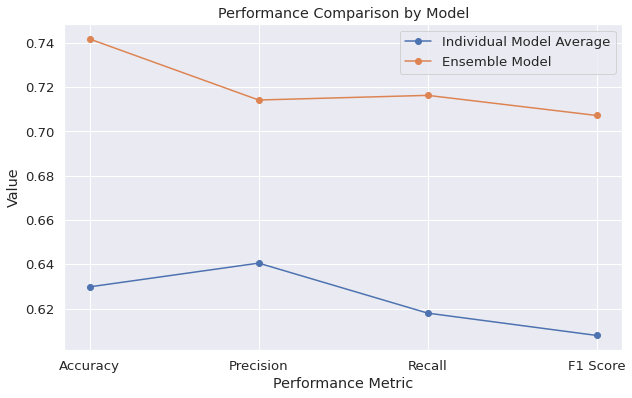

In [13]:
# 앙상블 모델의 성능 지표
ensemble_metrics = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]

# 개별 모델들의 평균 성능 지표 계산
average_metrics = [np.mean(model_accuracies), np.mean(model_precisions), np.mean(model_recalls), np.mean(model_f1s)]

# 성능 지표별로 그래프 그리기
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]  # "Percision"을 "Precision"으로 수정
plt.figure(figsize=(10, 6))

plt.plot(metrics, average_metrics, label="Individual Model Average", marker='o')
plt.plot(metrics, ensemble_metrics, label="Ensemble Model", marker='o')

plt.title("Performance Comparison by Model")
plt.xlabel("Performance Metric")
plt.ylabel("Value")
plt.legend()
plt.show()

In [14]:
import pandas as pd

# 개별 모델의 성능 지표를 리스트로 저장
individual_metrics = [
    ["개별 모델 평균 정확도", np.mean(model_accuracies)],
    ["개별 모델 평균 정밀도", np.mean(model_precisions)],
    ["개별 모델 평균 재현율", np.mean(model_recalls)],
    ["개별 모델 평균 F1 점수", np.mean(model_f1s)]
]

# 앙상블 모델의 성능 지표를 리스트로 저장
ensemble_metrics = [
    ["앙상블_정확도", ensemble_accuracy],
    ["앙상블_정밀도", ensemble_precision],
    ["앙상블_재현율", ensemble_recall],
    ["앙상블_F1 점수", ensemble_f1]
]

# 개별 모델과 앙상블 모델의 성능 지표를 DataFrame으로 생성
metrics_df = pd.DataFrame(individual_metrics + ensemble_metrics, columns=["지표", "값"])
metrics_df

,지표,값
0,개별 모델 평균 정확도,0.629781
1,개별 모델 평균 정밀도,0.640506
2,개별 모델 평균 재현율,0.617907
3,개별 모델 평균 F1 점수,0.607813
4,앙상블_정확도,0.741803
5,앙상블_정밀도,0.714217
6,앙상블_재현율,0.716320
7,앙상블_F1 점수,0.707222


- 앙상블 모델의 모든 성능평가지표가 개별모델의 평균보다 더 높은 값을 가지고 있음을 알 수 있습니다.
- 이는 앙상블 모델이 개별 모델들에 비해 더 좋은 성능을 나타낼 수 있음을 의미합니다.
- 다만, 이 결과만으로 앙상블 모델이 과적합에 강건한 모델인지를 판단할 수는 없습니다.
- 아래의 과적합 테스트를 통해 해당 부분을 확인해보겠습니다.

### 과적합 테스트

- 훈련 데이터와 테스트 데이터에 대한 성능 차이를 비교합니다. 
- 앙상블 모델이 훈련 데이터에 비해 테스트 데이터에서 성능이 덜 떨어진다면, 이는 과적합에 덜 취약하다는 것을 의미할 수 있습니다.

In [15]:
import numpy as np
import gc
from sklearn.metrics import accuracy_score

def ensemble_predictions(models, images, batch_size=8):
    num_samples = len(images)
    num_batches = int(np.ceil(num_samples / batch_size))
    total_predictions = None

    for i in range(num_batches):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        batch_predictions = None

        for model in models:
            pred = model.predict(batch_images)
            if batch_predictions is None:
                batch_predictions = pred
            else:
                batch_predictions += pred

        batch_predictions /= len(models)

        if total_predictions is None:
            total_predictions = batch_predictions
        else:
            total_predictions = np.vstack((total_predictions, batch_predictions))

    return total_predictions


def evaluate_model_in_batches(predictions, labels, batch_size=32):
    num_samples = len(labels)
    num_batches = int(np.ceil(num_samples / batch_size))
    total_accuracy = 0

    for i in range(num_batches):
        batch_pred_classes = predictions[i*batch_size:(i+1)*batch_size]
        batch_labels = labels[i*batch_size:(i+1)*batch_size]

        # 배치 정확도 계산
        batch_accuracy = accuracy_score(batch_labels, np.argmax(batch_pred_classes, axis=1))
        total_accuracy += batch_accuracy * len(batch_labels)

        # 메모리 해제
        del batch_pred_classes, batch_labels
        gc.collect()

    # 전체 정확도 계산
    overall_accuracy = total_accuracy / num_samples
    return overall_accuracy

#### 앙상블 모델 과적합 테스트

In [16]:
# 모델 평가를 위한 배치 크기 설정
batch_size = 16  # 배치 크기를 16으로 줄임

# 앙상블 모델의 예측 결과 생성
ensemble_train_pred = ensemble_predictions(models, train_images)
ensemble_valid_pred = ensemble_predictions(models, valid_images)

# 앙상블 모델의 훈련 및 검증 데이터셋 정확도 평가
ensemble_train_accuracy = evaluate_model_in_batches(ensemble_train_pred, train_labels, batch_size)
ensemble_valid_accuracy = evaluate_model_in_batches(ensemble_valid_pred, valid_labels, batch_size)

print("앙상블 모델")
print(f"훈련 데이터셋 정확도: {ensemble_train_accuracy}")
print(f"검증 데이터셋 정확도: {ensemble_valid_accuracy}\n")

앙상블 모델
훈련 데이터셋 정확도: 0.9773855488141202
검증 데이터셋 정확도: 0.7704918032786885



#### 개별모델 과적합 테스트

In [17]:
# 개별 모델 평가
for model in models:
    # 개별 모델의 예측 결과 생성
    model_train_pred = model.predict(train_images)
    model_valid_pred = model.predict(valid_images)

    # 개별 모델의 훈련 및 검증 데이터셋 정확도 평가
    model_train_accuracy = evaluate_model_in_batches(model_train_pred, train_labels, batch_size)
    model_valid_accuracy = evaluate_model_in_batches(model_valid_pred, valid_labels, batch_size)

    print(f"모델: {model.name}")
    print(f"훈련 데이터셋 정확도: {model_train_accuracy}")
    print(f"검증 데이터셋 정확도: {model_valid_accuracy}\n")

    # 메모리 해제
    del model_train_pred, model_valid_pred, model_train_accuracy, model_valid_accuracy
    gc.collect()

모델: sequential_1
훈련 데이터셋 정확도: 0.9884169884169884
검증 데이터셋 정확도: 0.7814207650273224

모델: sequential
훈련 데이터셋 정확도: 0.7010479867622724
검증 데이터셋 정확도: 0.46994535519125685

모델: sequential
훈련 데이터셋 정확도: 0.9349145063430778
검증 데이터셋 정확도: 0.7540983606557377

모델: sequential_1
훈련 데이터셋 정확도: 0.9884169884169884
검증 데이터셋 정확도: 0.7814207650273224

모델: sequential
훈련 데이터셋 정확도: 0.7010479867622724
검증 데이터셋 정확도: 0.46994535519125685

모델: sequential
훈련 데이터셋 정확도: 0.9349145063430778
검증 데이터셋 정확도: 0.7540983606557377



- 개별 모델중 가장 높은 성능을 지닌 모델은 equential_1입니다.
- 앙상블 모델의 검증 데이터셋 정확도가 개별 모델 중 가장 높은 성능을 가진 모델과 비슷한 수준으로 나타납니다. 
- 이로써 앙상블 모델은 과적합을 방지하고, 검증 데이터셋에서도 좋은 성능을 보여주고 있음을 알 수 있습니다.
- 앙상블 모델은 여러 개의 개별 모델의 예측을 평균화하여 보다 일반화된 예측을 제공하는 데 도움이 됩니다. 
- 따라서 앙상블 모델을 사용함으로써 모델의 성능을 향상시킬 수 있었음을 확인할 수 있습니다.